In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from scipy.stats import entropy

In [4]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import *

from keras.datasets import fashion_mnist, mnist

Using TensorFlow backend.


In [5]:
from gradient_reversal_keras_tf.gradient_reversal_layer import GradientReversal
from utils import *

# Loading and preparing data

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)

x_train = x_train / 255.
x_test = x_test / 255.

In [8]:
BATCH_SIZE = 32
N_EPOCH = 32

INPUT_DIM = x_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 256

# Simple AE

### Definition and training

In [9]:
# Encoder
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)
           
encoder = Model(inp_e, e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Stacking all together
inp_x = Input((INPUT_DIM,))
reconstruction = decoder(encoder(inp_x))

trainable = Model(inp_x, reconstruction)
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

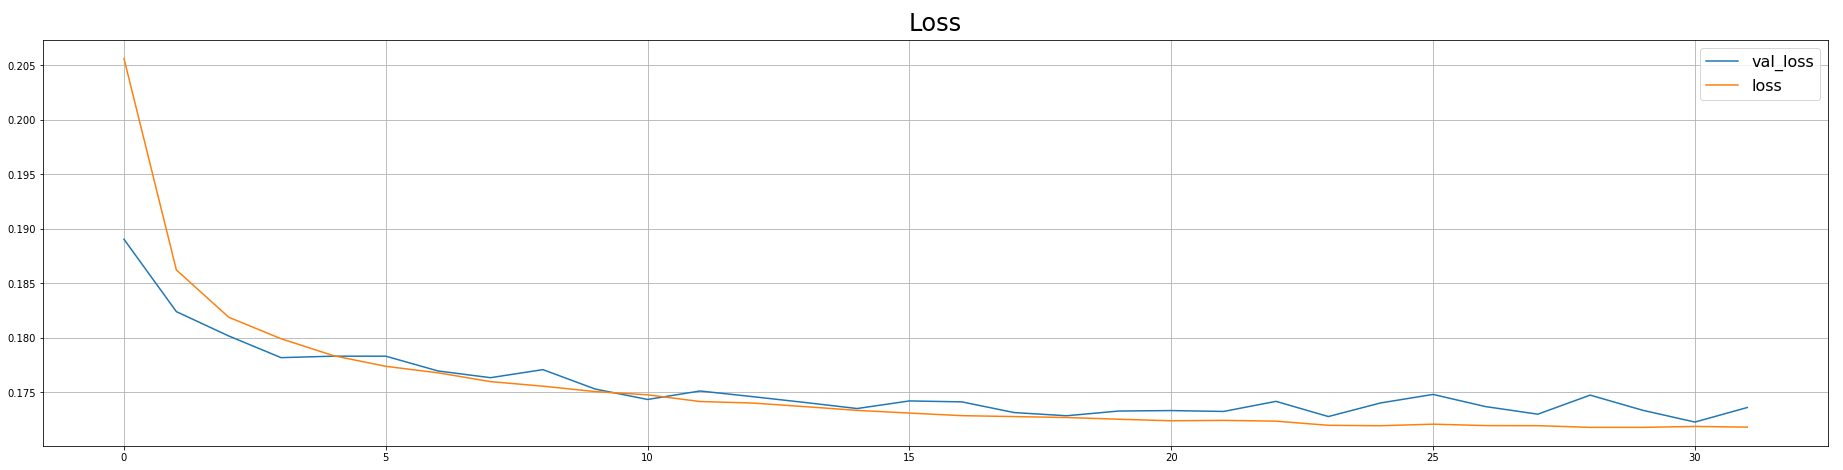

In [10]:
trainable.fit(x=x_train, y=x_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=0, validation_data=(x_test, x_test), shuffle=True,
              callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'loss', 'constants':{}},))])

### Results

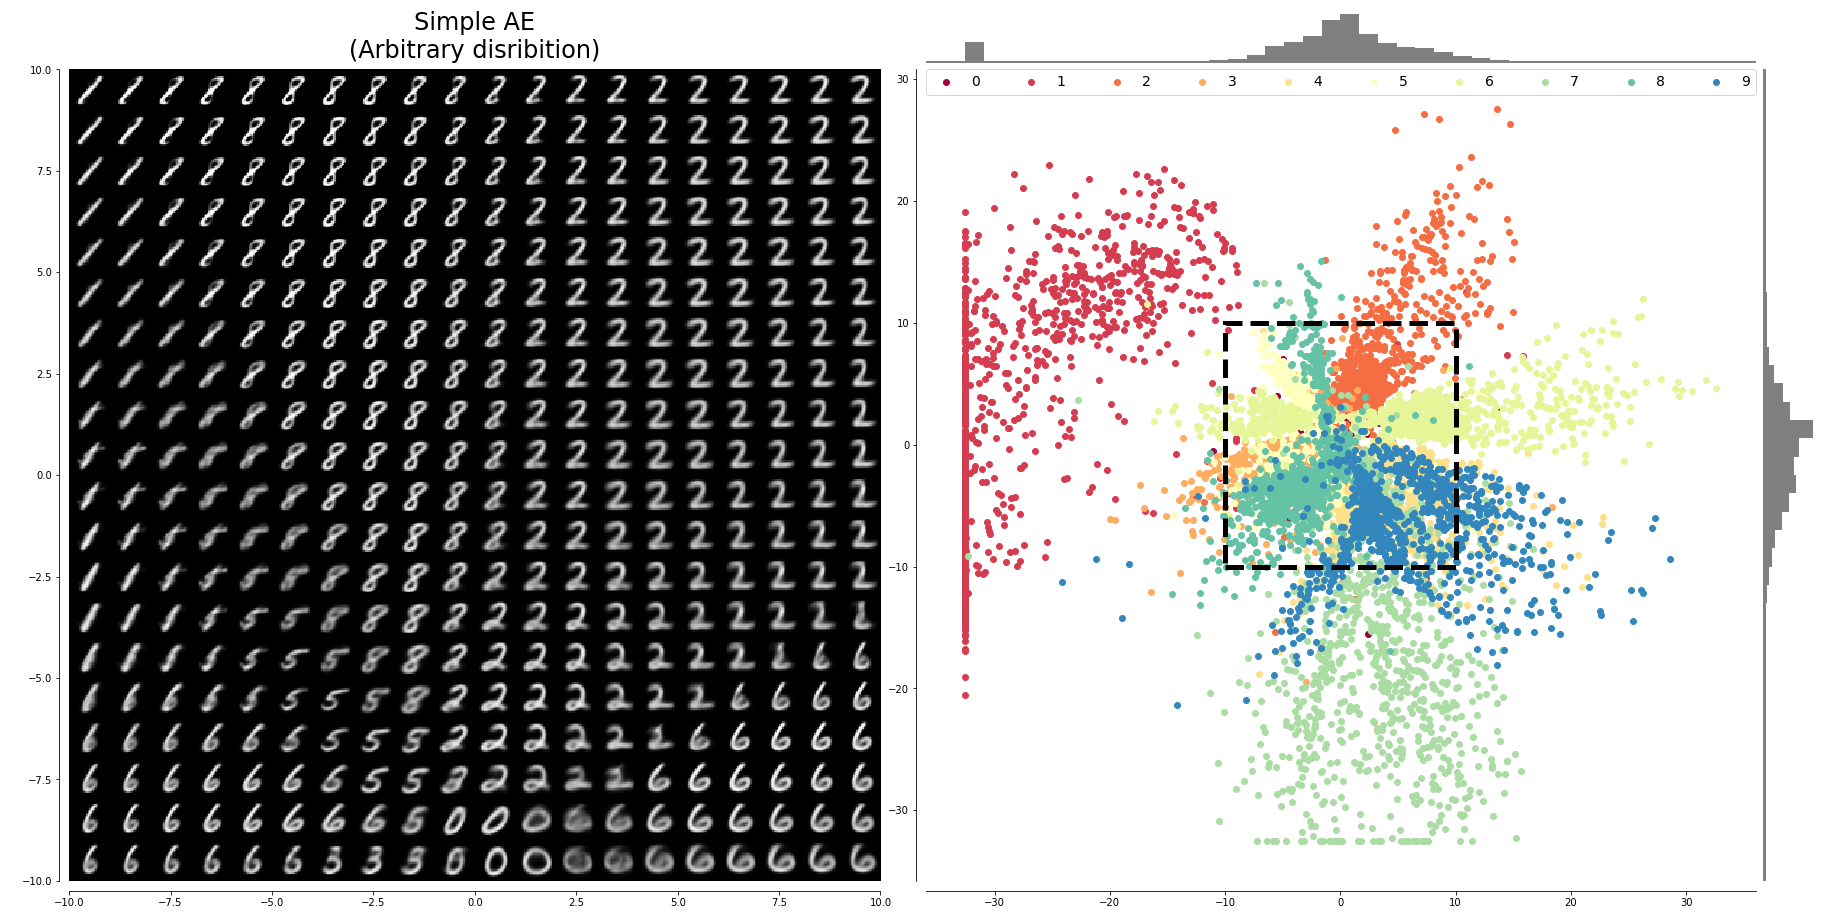

In [11]:
n_points = 20
z_range = (-10, 10)
z_samples = np.arange(z_range[0], z_range[1], (z_range[1] - z_range[0]) / n_points)
z_samples = np.array([(z1, z_range[1] - z2) for z1 in z_samples for z2 in z_samples])

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points = encoder.predict(x_test)
z_points = np.clip(z_points, -3 * z_points.std(), 3 * z_points.std())
z1, z2 = z_points.T

visualize('Simple AE\n(Arbitrary disribition)', x_samples_img, z_range, z_points, y_test)

Entropy

In [12]:
Q, _ = np.histogram(z_points, bins=100, range=(-1, 1), density=True)
P, _ = np.histogram(np.random.normal(size=z_points.shape), bins=100, range=(-1, 1), density=True)
entropy(P, Q)

0.025492631527460445

# Deterministic AAE

### Definition and training

In [13]:
# Encoder
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)
           
encoder = Model(inp_e, e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder(inp_x))
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(encoder(inp_x)))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

trainable = Model([inp_x, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [14]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                prior_samples = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, prior_samples], [X, zeros, ones]
                
    return generator(), n_steps

In [15]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

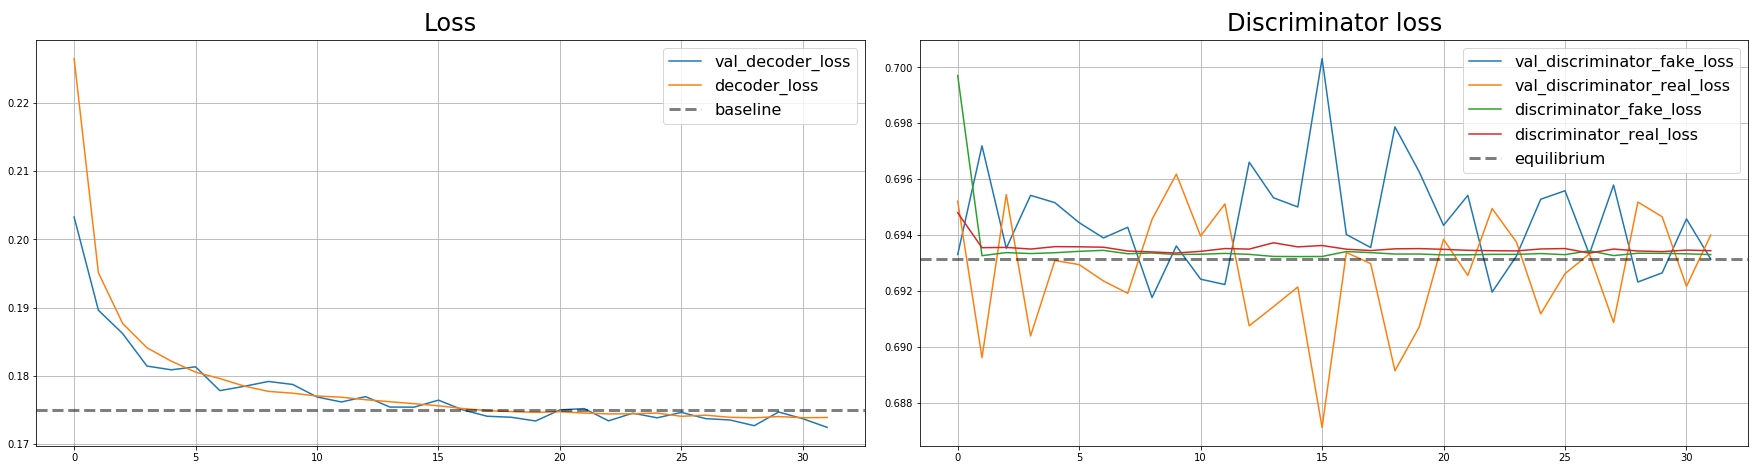

In [16]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'baseline': 0.175}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

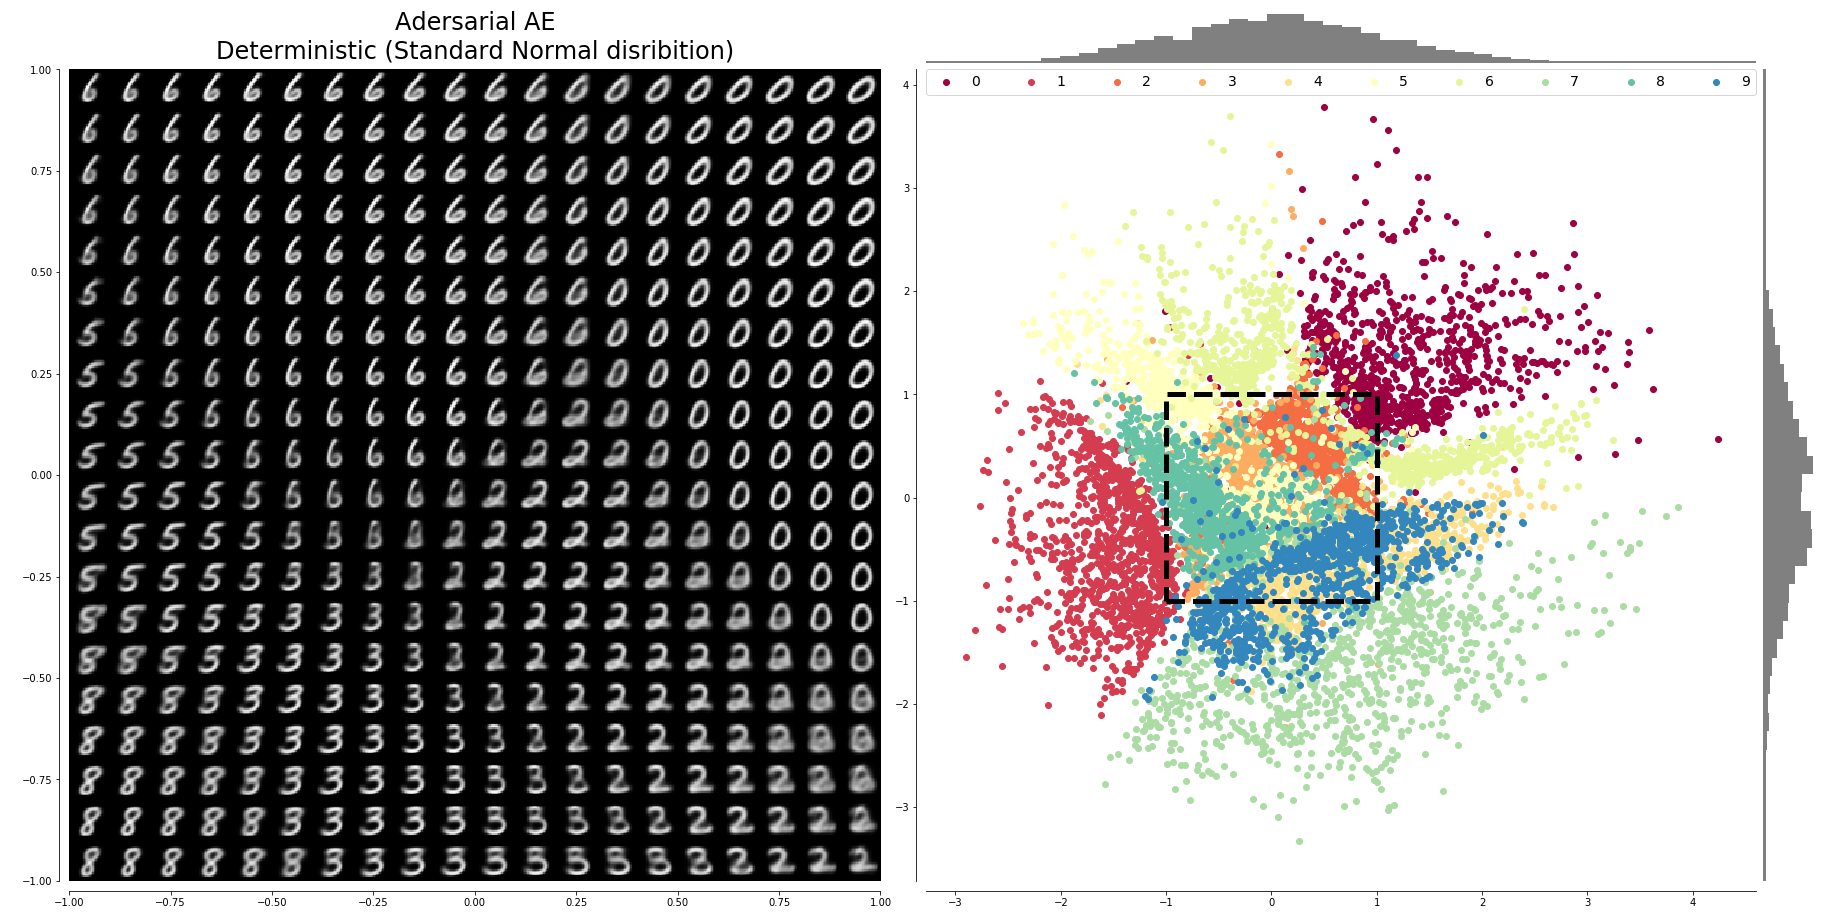

In [17]:
n_points = 20
z_range = (-1, 1)
z_samples = np.arange(z_range[0], z_range[1], (z_range[1] - z_range[0]) / n_points)
z_samples = np.array([(z1, z_range[1] - z2) for z1 in z_samples for z2 in z_samples])

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points = encoder.predict(x_test)
z1, z2 = z_points.T

visualize('Adersarial AE\nDeterministic (Standard Normal disribition)', x_samples_img, z_range, z_points, y_test)

<br>Statistics...

In [18]:
z_samples.mean(), z_samples.std()

(0.5, 0.7968688725254615)

Entropy

In [19]:
Q, _ = np.histogram(z_points, bins=100, range=(-1, 1), density=True)
P, _ = np.histogram(np.random.normal(size=z_points.shape), bins=100, range=(-1, 1), density=True)
entropy(P, Q)

0.010164803417541918

# Gaussian posterior

### Definition and training

In [20]:
# Encoder
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)

# Reparametrization trick
z_mean = Dense(LATENT_DIM)(e)
z_log_sigma = Dense(LATENT_DIM)(e)
z_code = Lambda(lambda x: x[0] + K.exp(x[1]) * K.random_normal(shape=K.shape(x[0])))([z_mean, z_log_sigma])
           
encoder = Model(inp_e, [z_code, z_mean, z_log_sigma], name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder(inp_x)[0])
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(encoder(inp_x)[0]))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

trainable = Model([inp_x, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [21]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                prior_samples = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, prior_samples], [X, zeros, ones]
                
    return generator(), n_steps

In [22]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

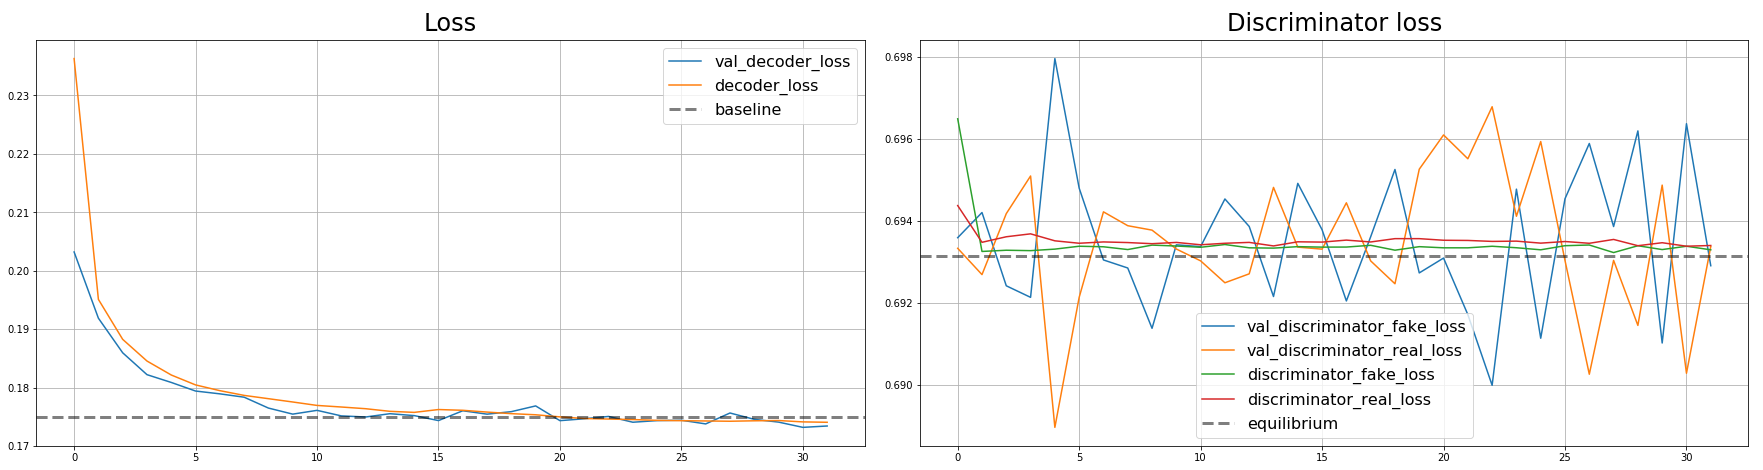

In [23]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'baseline': 0.175}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

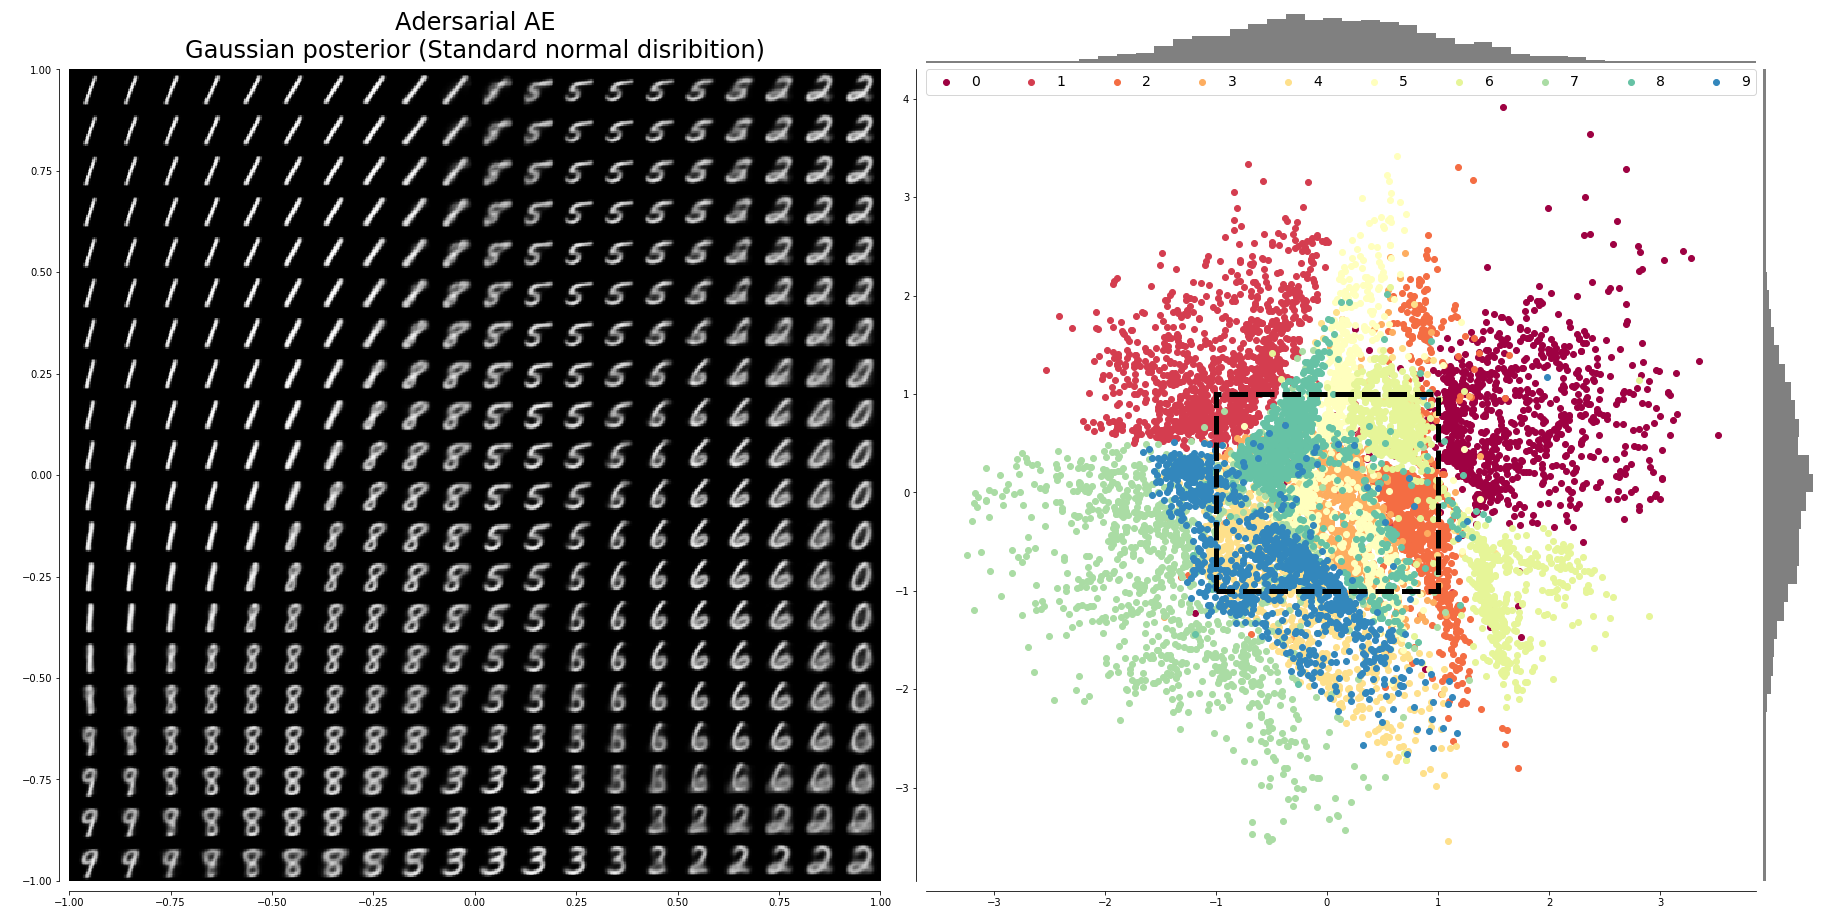

In [24]:
n_points = 20
z_range = (-1, 1)
z_samples = np.arange(z_range[0], z_range[1], (z_range[1] - z_range[0]) / n_points)
z_samples = np.array([(z1, z_range[1] - z2) for z1 in z_samples for z2 in z_samples])

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points, z_mean_test, z_log_sigma_test = encoder.predict(x_test)
z1, z2 = z_points.T

visualize('Adersarial AE\nGaussian posterior (Standard normal disribition)', x_samples_img, z_range, z_points, y_test)

<br>Statistics

In [25]:
z_samples.mean(), z_samples.std()

(0.5, 0.7968688725254615)

In [26]:
z_mean_test.mean(), z_mean_test.std()

(0.013201075, 1.0101112)

In [27]:
np.exp(z_log_sigma_test).mean(), np.exp(z_log_sigma_test).std()

(2.5972926e-05, 0.00024527087)

<br>Kullback–Leibler divergence

In [28]:
np.mean(-0.5 * np.mean(1 + z_log_sigma_test - np.square(z_mean_test) - np.exp(z_log_sigma_test), axis=-1))

10.951645

Entropy

In [29]:
Q, _ = np.histogram(z_points, bins=100, range=(-1, 1), density=True)
P, _ = np.histogram(np.random.normal(size=z_points.shape), bins=100, range=(-1, 1), density=True)
entropy(P, Q)

0.006969376111814425

# Universal approximator posterior (Beta)

### Definition and training

In [30]:
# Encoder
inp_encoder_x = Input((INPUT_DIM,))
inp_encoder_noise = Input((LATENT_DIM,))
e = concatenate([inp_encoder_x, inp_encoder_noise])

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='sigmoid')(e)

encoder = Model([inp_encoder_x, inp_encoder_noise], e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
inp_noise = Input((LATENT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder([inp_x, inp_noise]))
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(encoder([inp_x, inp_noise])))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

trainable = Model([inp_x, inp_noise, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [31]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                input_noise = np.random.uniform(-1, 1, size=(batch_size, LATENT_DIM))
                prior_samples = np.random.beta(0.5, 0.5, (batch_size, LATENT_DIM))
                
                yield [X, input_noise, prior_samples], [X, zeros, ones]
                
    return generator(), n_steps

In [32]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

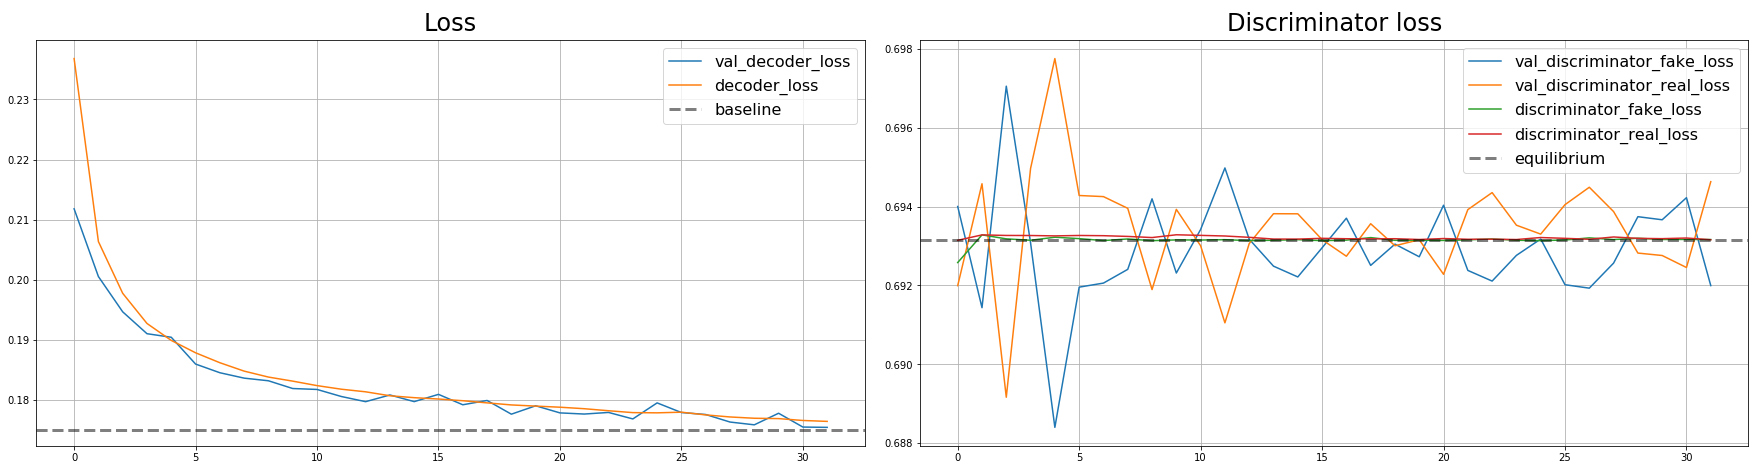

In [33]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'baseline': 0.175}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

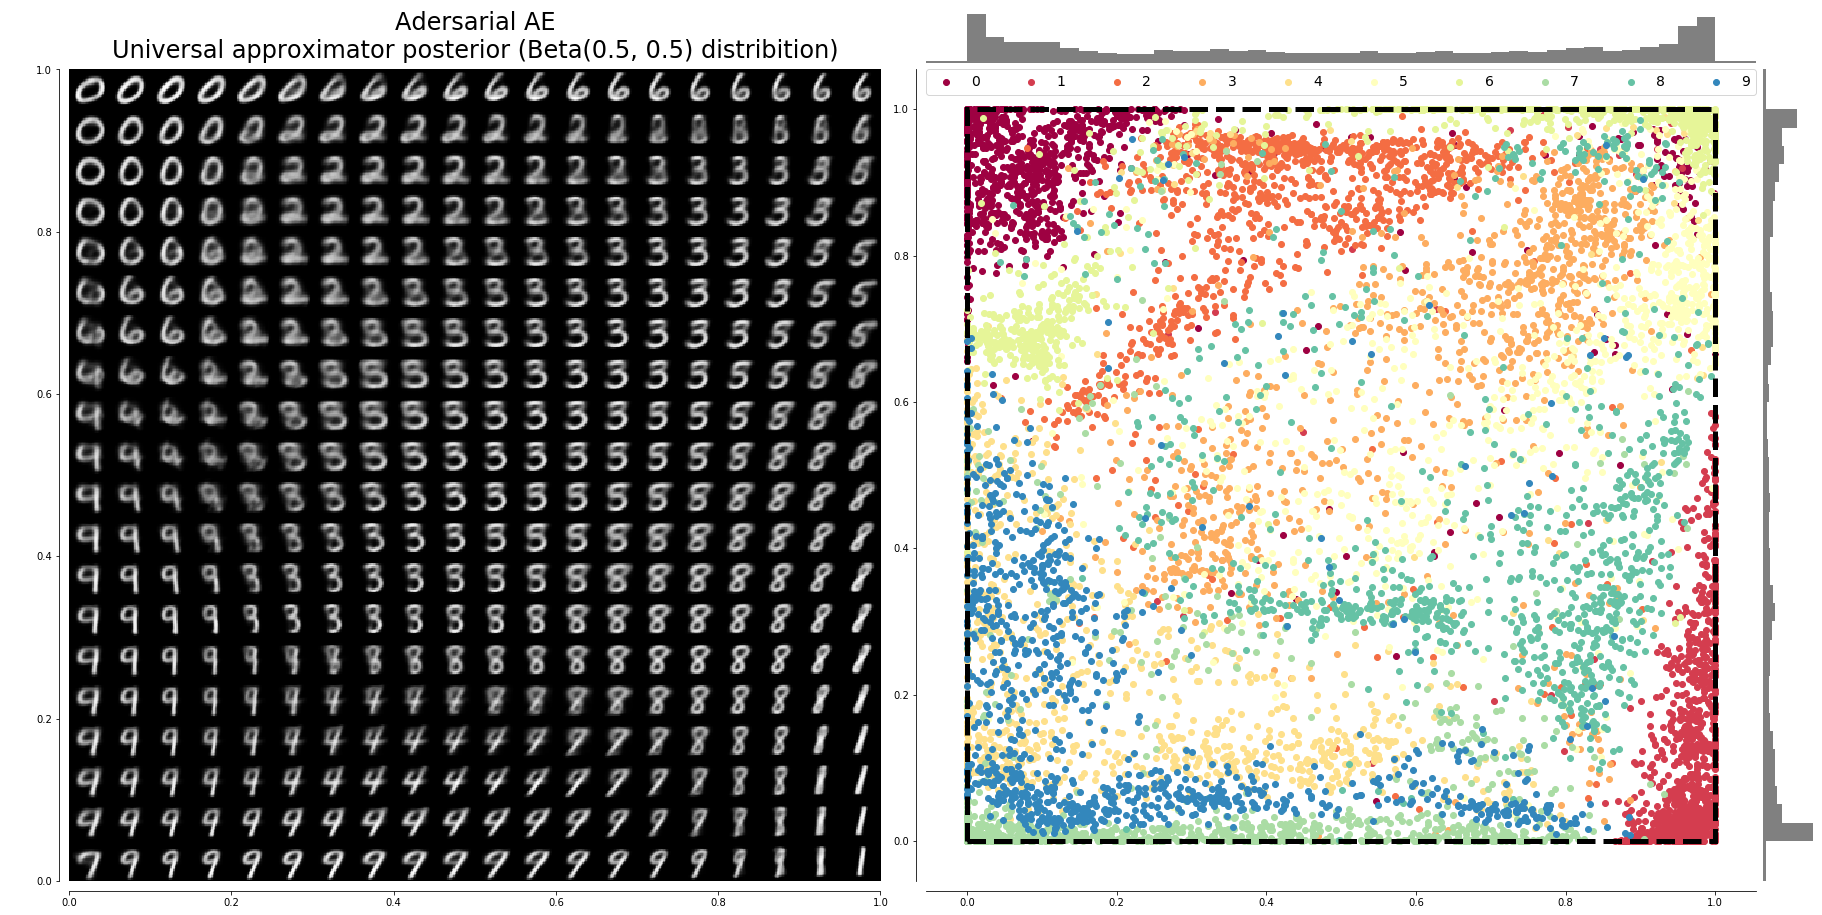

In [34]:
n_points = 20
z_range = (0, 1)
z_samples = np.arange(z_range[0], z_range[1], (z_range[1] - z_range[0]) / n_points)
z_samples = np.array([(z1, z_range[1] - z2) for z1 in z_samples for z2 in z_samples])

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points = encoder.predict([x_test, np.random.uniform(-1, 1, size=(x_test.shape[0], LATENT_DIM))])
z1, z2 = z_points.T

visualize('Adersarial AE\nUniversal approximator posterior (Beta(0.5, 0.5) distribition)', x_samples_img, z_range, z_points, y_test)

<br>Statistics...

In [35]:
z_samples.mean(), z_samples.std()

(0.5, 0.28939592256975566)

Entropy...

In [37]:
Q, _ = np.histogram(z_points, bins=100, range=(0, 1), density=True)
P, _ = np.histogram(np.random.beta(0.5, 0.5, size=z_points.shape), bins=100, range=(0, 1), density=True)
entropy(P, Q)

0.01682297625161058

# Universal approximator posterior (Swiss Roll)

In [38]:
from sklearn.datasets import make_swiss_roll

### Definition and training

In [39]:
# Encoder
inp_encoder_x = Input((INPUT_DIM,))
inp_encoder_noise = Input((LATENT_DIM,))
e = concatenate([inp_encoder_x, inp_encoder_noise])

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)

encoder = Model([inp_encoder_x, inp_encoder_noise], e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
inp_noise = Input((LATENT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder([inp_x, inp_noise]))
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(encoder([inp_x, inp_noise])))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

trainable = Model([inp_x, inp_noise, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile(keras.optimizers.adam(1e-4), 'binary_crossentropy')
# trainable.summary()

In [40]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    N, _ = make_swiss_roll(n_samples=len(data), noise=0., random_state=42)
    N = N[:,[0, 2]]
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                input_noise = np.random.uniform(-1, 1, size=(batch_size, LATENT_DIM))
                prior_samples = N[np.random.randint(len(N), size=batch_size)] + np.random.normal(scale=0.1, size=(batch_size, LATENT_DIM))
                prior_samples /= 10.
                
                yield [X, input_noise, prior_samples], [X, zeros, ones]
                
    return generator(), n_steps

In [41]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

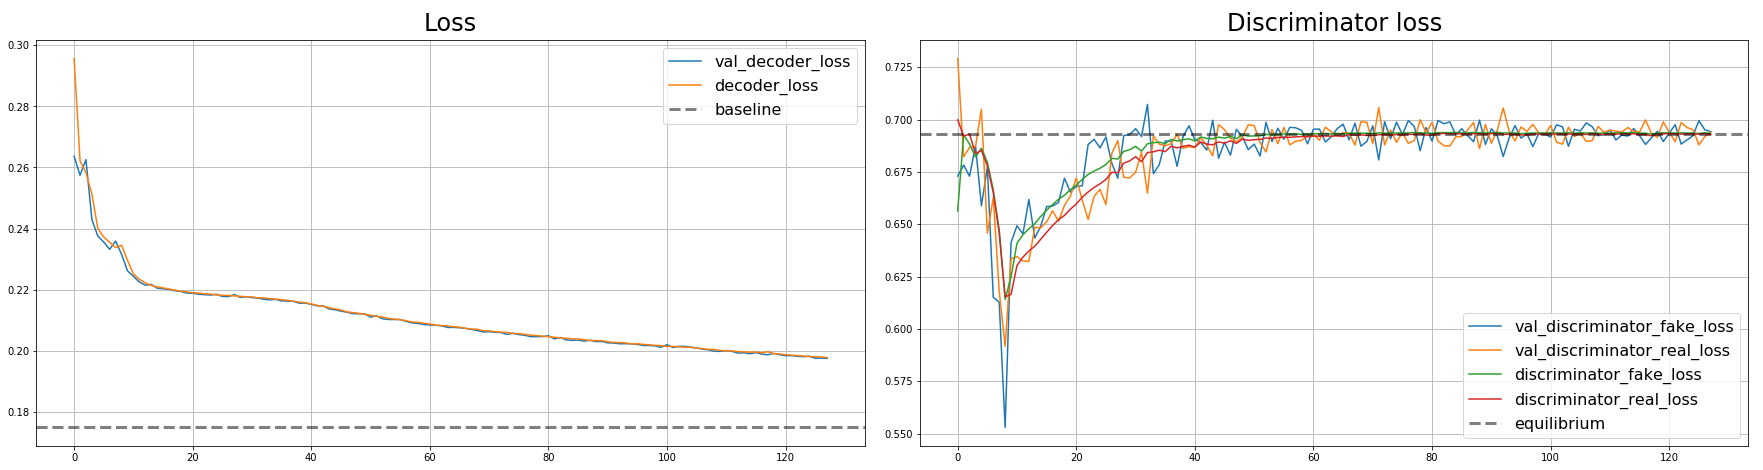

In [42]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH * 4, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'baseline': 0.175}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

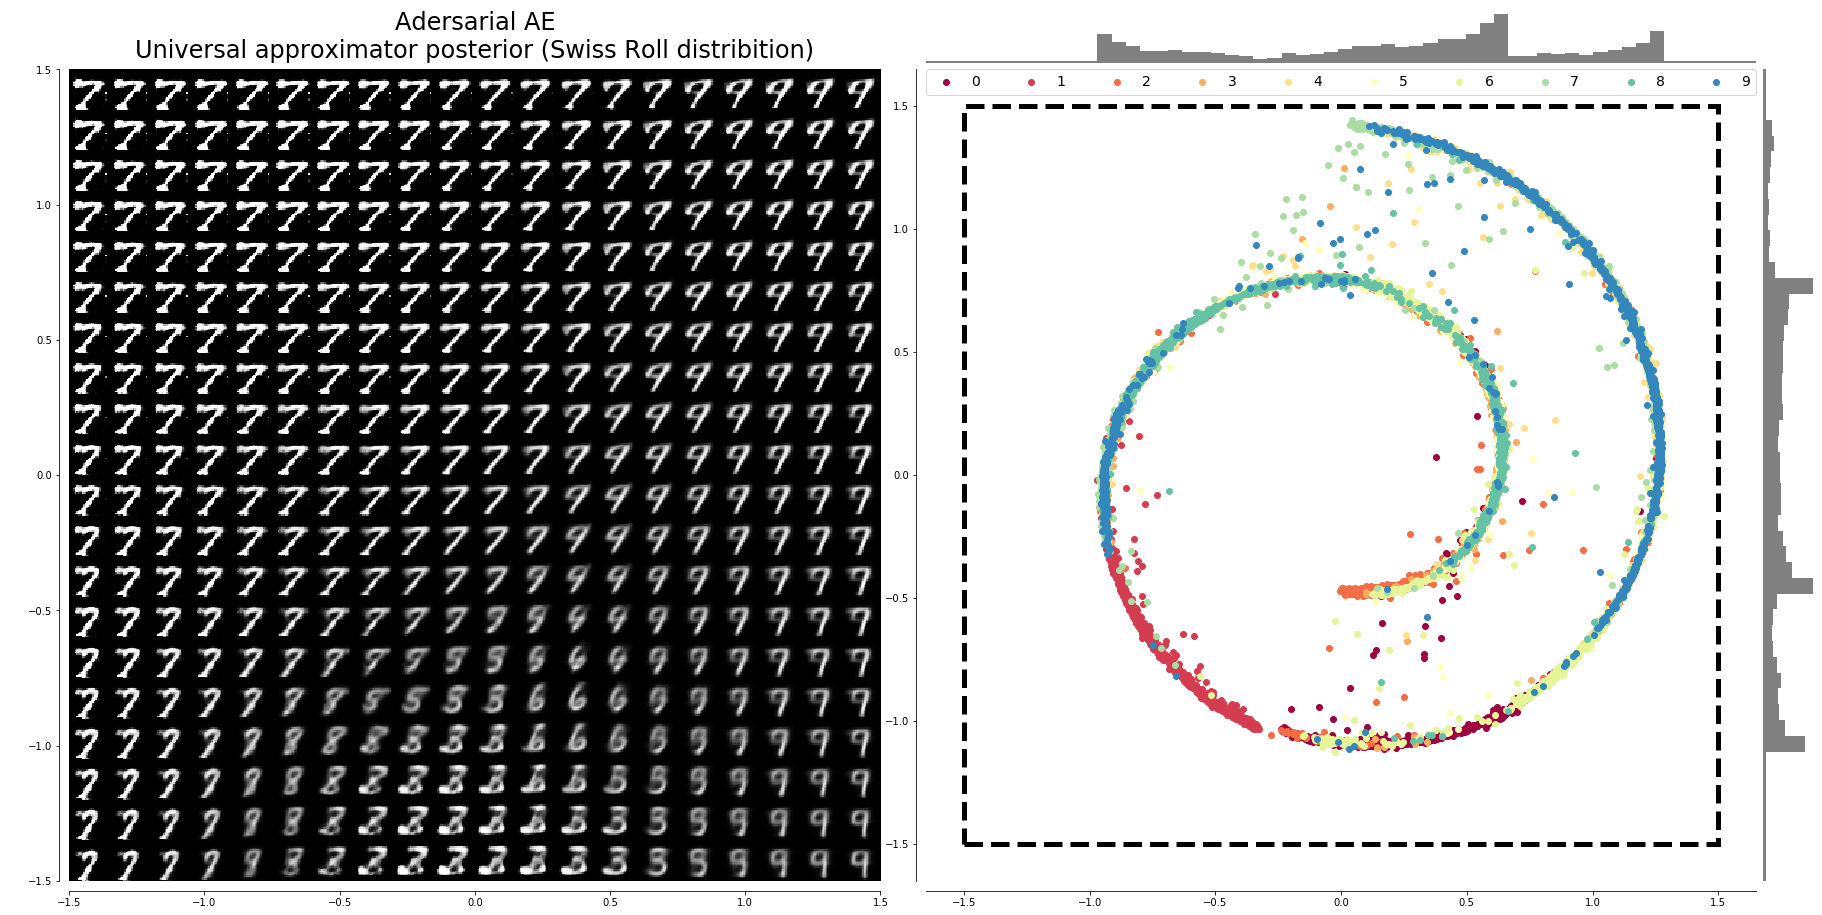

In [43]:
n_points = 20
z_range = (-1.5, 1.5)
z_samples = np.arange(z_range[0], z_range[1], (z_range[1] - z_range[0]) / n_points)
z_samples = np.array([(z1, z_range[1] - z2) for z1 in z_samples for z2 in z_samples])

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points = encoder.predict([x_test, np.random.uniform(-1, 1, size=(x_test.shape[0], LATENT_DIM))])
z1, z2 = z_points.T

visualize('Adersarial AE\nUniversal approximator posterior (Swiss Roll distribition)', x_samples_img, z_range, z_points, y_test)

# Universal approximator posterior (Awesome Face)

In [44]:
import re
import numpy as np
from numpy import sin, sqrt, heaviside
from numpy import sign as sgn
from numpy import pi as π

θ = lambda x: heaviside(x, 0.5)

# raw text from Wolfram Alpha
x_raw = '((-14/5 sin(11/7 - 10 t) + 2942/7 sin(t + 16/5) + 43/5 sin(2 t + 39/10) + 123/4 sin(3 t + 3/7) + 10 sin(4 t + 3/5) + 39/4 sin(5 t + 15/4) + 44/7 sin(6 t + 49/12) + 7/2 sin(7 t + 1) + 29/7 sin(8 t + 8/7) + 5/4 sin(9 t + 23/6) + 67/5) θ(31 π - t) θ(t - 27 π) + (-22/5 sin(4/3 - 8 t) + 1841/6 sin(t + 19/7) + 357/4 sin(2 t + 23/11) + 106/3 sin(3 t + 4) + 351/14 sin(4 t + 1/14) + 127/8 sin(5 t + 22/7) + 36/5 sin(6 t + 33/7) + 91/18 sin(7 t + 22/9) + 23/6 sin(9 t + 1/5) + 17/6 sin(10 t + 9/2) - 4019/4) θ(27 π - t) θ(t - 23 π) + (-61/15 sin(8/9 - 8 t) - 51/5 sin(4/3 - 6 t) + 1453/4 sin(t + 14/5) + 614/7 sin(2 t + 13/6) + 75/2 sin(3 t + 13/3) + 122/5 sin(4 t + 1/16) + 175/11 sin(5 t + 13/4) + 19/4 sin(7 t + 9/5) + 5 sin(9 t + 1/2) + 13/7 sin(10 t + 4) + 1198/3) θ(23 π - t) θ(t - 19 π) + (-14/3 sin(2/5 - 6 t) - 29/5 sin(5/9 - 5 t) - 37/4 sin(1/3 - 4 t) + 3021/7 sin(t + 97/32) + 179/9 sin(2 t + 34/11) + 53/5 sin(3 t + 29/10) + 1/2 sin(7 t + 18/5) + 11/6 sin(8 t + 16/7) + 11/5 sin(9 t + 7/3) + 5/6 sin(10 t + 11/5) - 13027/13) θ(19 π - t) θ(t - 15 π) + (-3/5 sin(1/6 - 10 t) - 23/7 sin(2/7 - 6 t) - 23/3 sin(1/8 - 5 t) - 10 sin(1/5 - 4 t) + 2417/5 sin(t + 34/11) + 89/4 sin(2 t + 16/5) + 11/5 sin(3 t + 14/5) + 31/16 sin(7 t + 17/6) + 20/7 sin(8 t + 23/8) + 17/7 sin(9 t + 11/4) + 785/2) θ(15 π - t) θ(t - 11 π) + (-2 sin(4/3 - 16 t) - 39/11 sin(6/5 - 14 t) - 21/4 sin(14/9 - 12 t) - 41/3 sin(3/2 - 6 t) + 5028/5 sin(t + 23/12) + 713/14 sin(2 t + 17/5) + 103/3 sin(3 t + 7/3) + 258/7 sin(4 t + 13/3) + 142/13 sin(5 t + 1) + 179/15 sin(7 t + 9/7) + 17/3 sin(8 t + 13/3) + 47/6 sin(9 t + 5/3) + 90/13 sin(10 t + 22/5) + 18/5 sin(11 t + 13/7) + 18/5 sin(13 t + 7/5) + 26/7 sin(15 t + 7/4) - 1087/5) θ(11 π - t) θ(t - 7 π) + (8875/6 sin(t + 28/9) - 277/3) θ(7 π - t) θ(t - 3 π) + (4832/3 sin(t + 31/10) - 467/5) θ(3 π - t) θ(t + π)) θ(sqrt(sgn(sin(t/2))))'
y_raw = '((-1/3 sin(4/3 - 10 t) - 21/22 sin(3/5 - 9 t) - 4 sin(7/5 - 5 t) - 21/4 sin(1/4 - 4 t) + 4217/17 sin(t + 9/2) + 74/3 sin(2 t + 15/7) + 32/3 sin(3 t + 11/7) + 7/4 sin(6 t + 16/5) + 2 sin(7 t + 13/6) + 4/5 sin(8 t + 2/3) - 6393/7) θ(31 π - t) θ(t - 27 π) + (-209/6 sin(1/5 - 4 t) - 249/8 sin(6/5 - 3 t) + 577/2 sin(t + 40/9) + 184/3 sin(2 t + 9/4) + 83/7 sin(5 t + 2/3) + 25/3 sin(6 t + 12/5) + 5 sin(7 t + 17/6) + 5/3 sin(8 t + 1/7) + 23/6 sin(9 t + 1/4) + 5/4 sin(10 t + 5/4) + 4843/9) θ(27 π - t) θ(t - 23 π) + (-131/4 sin(4/5 - 3 t) + 1781/6 sin(t + 9/2) + 422/7 sin(2 t + 9/4) + 189/5 sin(4 t + 1/16) + 79/6 sin(5 t + 8/5) + 34/3 sin(6 t + 26/9) + 22/5 sin(7 t + 23/7) + 35/12 sin(8 t + 2/7) + 11/4 sin(9 t + 5/7) + 14/5 sin(10 t + 10/3) + 5301/10) θ(23 π - t) θ(t - 19 π) + (401 sin(t + 23/5) + 118/3 sin(2 t + 7/5) + 68/3 sin(3 t + 6/5) + 133/8 sin(4 t + 6/5) + 11/3 sin(5 t + 4/3) + 24/7 sin(6 t + 57/14) + 34/7 sin(7 t + 45/11) + 25/7 sin(8 t + 37/9) + 1/3 sin(9 t + 19/5) + 9/5 sin(10 t + 3/5) + 2127/4) θ(19 π - t) θ(t - 15 π) + (13121/32 sin(t + 14/3) + 44 sin(2 t + 10/7) + 123/4 sin(3 t + 7/5) + 15 sin(4 t + 4/3) + 3/4 sin(5 t + 12/5) + 27/5 sin(6 t + 13/3) + 40/7 sin(7 t + 31/7) + 13/6 sin(8 t + 13/3) + 6/5 sin(9 t + 6/5) + 58/19 sin(10 t + 1) + 3688/7) θ(15 π - t) θ(t - 11 π) + (-19/7 sin(8/7 - 12 t) - 103/5 sin(7/8 - 5 t) - 80/9 sin(11/7 - 4 t) + 3665/6 sin(t + 18/5) + 803/6 sin(2 t + 13/5) + 441/8 sin(3 t + 9/2) + 17/2 sin(6 t + 4/5) + 27/5 sin(7 t + 1/3) + 17/3 sin(8 t + 2) + 9/5 sin(9 t + 24/7) + 15/4 sin(10 t + 26/7) + 13/5 sin(11 t + 41/9) + 16/17 sin(13 t + 1/5) + 23/11 sin(14 t + 1/4) + 7/4 sin(15 t + 25/12) + 2/3 sin(16 t + 9/7) - 9879/19) θ(11 π - t) θ(t - 7 π) + (5913/4 sin(t + 14/3) + 1105/12) θ(7 π - t) θ(t - 3 π) + (8012/5 sin(t + 14/3) + 359/4) θ(3 π - t) θ(t + π)) θ(sqrt(sgn(sin(t/2))))'

format_mul = re.compile(r'(\d+|\))\s(t|θ|π|sin|sgn|sqrt|\d+)')

x_compiled = compile(format_mul.sub(r'\g<1>*\g<2>', x_raw), '<string>', 'eval')
y_compiled = compile(format_mul.sub(r'\g<1>*\g<2>', y_raw), '<string>', 'eval')

x = np.vectorize(lambda t: eval(x_compiled))
y = np.vectorize(lambda t: eval(y_compiled))

def make_awesome_face(n_samples=100, noise=0.0, random_state=None, filter_nan=True):
    t = np.arange(0, 32*π, 32*π/n_samples)
    
    X = np.zeros((n_samples, 2))
    X[:,0] = x(t)
    X[:,1] = y(t)
    X = X / 150 + np.random.RandomState(random_state).normal(scale=noise, size=(n_samples, 2))
    X = X / 10
    if filter_nan:
        X = X[~np.isnan(X).any(axis=1)]
    
    return X

### Definition and training

In [45]:
# Encoder
inp_encoder_x = Input((INPUT_DIM,))
inp_encoder_noise = Input((LATENT_DIM,))
e = concatenate([inp_encoder_x, inp_encoder_noise])

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)

encoder = Model([inp_encoder_x, inp_encoder_noise], e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
e = Dense(HIDDEN_DIM, activation='relu')(e)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
inp_noise = Input((LATENT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder([inp_x, inp_noise]))
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(encoder([inp_x, inp_noise])))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

trainable = Model([inp_x, inp_noise, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile(keras.optimizers.adam(lr=1e-4), 'binary_crossentropy')
# trainable.summary()

In [46]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    N = make_awesome_face(n_samples=60000, filter_nan=True)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                input_noise = np.random.uniform(-1, 1, size=(batch_size, LATENT_DIM))
                prior_samples = N[np.random.randint(len(N), size=batch_size)] + np.random.normal(scale=0.01, size=(batch_size, LATENT_DIM))
                
                yield [X, input_noise, prior_samples], [X, zeros, ones]
                
    return generator(), n_steps

In [47]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

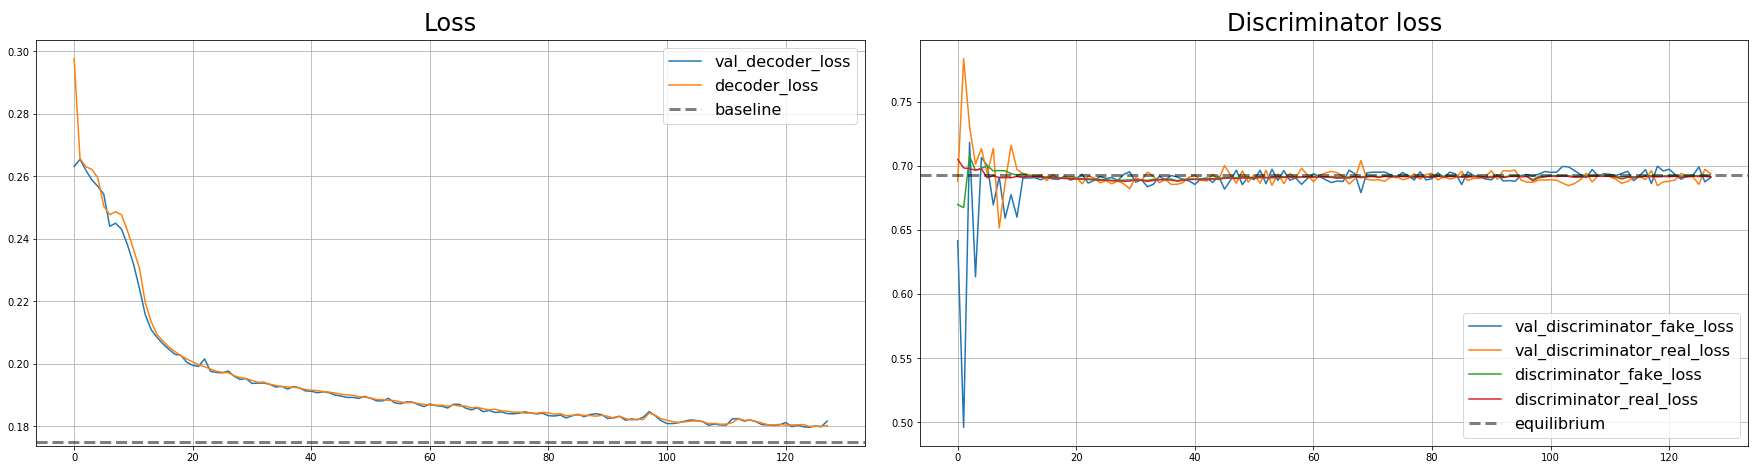

In [48]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH * 4, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'baseline': 0.175}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

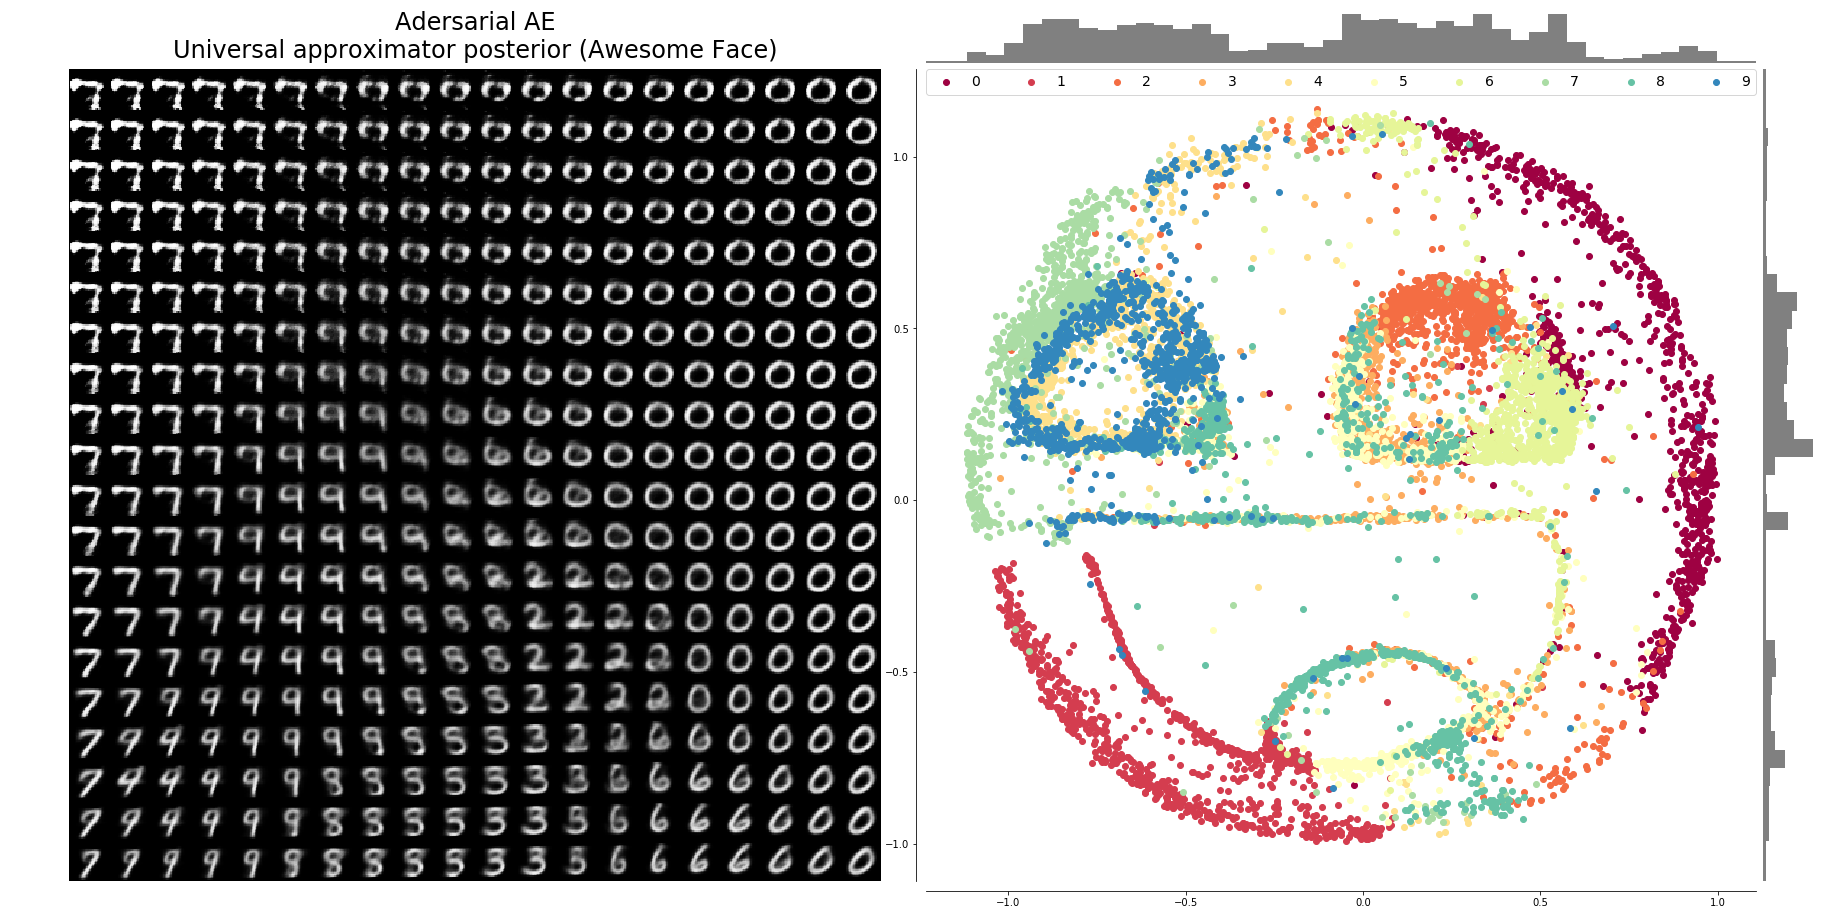

In [49]:
n_points = 20
z_range = (-1, 1)
z_samples = np.arange(z_range[0], z_range[1], (z_range[1] - z_range[0]) / n_points)
z_samples = np.array([(z1, z_range[1] - z2) for z1 in z_samples for z2 in z_samples])

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points = encoder.predict([x_test, np.random.uniform(-1, 1, size=(x_test.shape[0], LATENT_DIM))])
z1, z2 = z_points.T

visualize('Adersarial AE\nUniversal approximator posterior (Awesome Face)', x_samples_img, None, z_points, y_test)